# EDA on #bigdata with Azure ML and Dask

## Environment setup

This notebook assumes you are using an Azure ML Compute Instance with the default kernel `azureml_py36`. This contains many unneccesary packages. If you want to avoid a long image build time, you may want to create a new conda environment with the minimal packages needed for your scenario. 

It is important that the local environment matches the remote environment to avoid mismatch issues when submitting commands to the remote cluster. To help with this, we will use Azure ML Environments. 

In [ ]:
pip install --upgrade dask[complete] adlfs lz4 distributed fastparquet pyarrow azureml-sdk[notebooks]

In [ ]:
pip uninstall azureml-samples azureml-mlflow -y

## Important! 

Restart your kernel

In [ ]:
# this is for a strange bug with compute instances 
import os

os.system('sudo cp /etc/nginx/nginx.conf setup/temp.conf') # stupid

nginx = ''

with open('setup/temp.conf') as f:
    for line in f.readlines():
        if 'websocket/|/ws/' in line:
            nginx += line.replace('websocket/|/ws/', 'websocket/|/ws')
        else:
            nginx += line
       
with open('setup/temp2.conf', 'w') as f:
    f.write(nginx)
    
os.system('sudo mv setup/temp2.conf /etc/nginx/nginx.conf')
os.system('sudo service nginx restart')
os.system('rm setup/temp.conf');

## Imports

Import all packages used in this notebook.

In [1]:
import os
import sys
import dask
import glob
import time
import socket
import matplotlib

import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

from datetime import datetime
from dask.distributed import Client
from IPython.core.display import HTML

from azureml.widgets import RunDetails
from azureml.train.estimator import Estimator
from azureml.core.runconfig import MpiConfiguration
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.conda_dependencies import CondaDependencies 
from azureml.core import Workspace, Experiment, Dataset, Environment

%matplotlib inline 

Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception cannot import name '_DistributedTraining'.


## Azure ML setup

Get the workspace.

In [2]:
ws = Workspace.from_config()
ws

Workspace.create(name='dask', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='cody-daskv2-rg')

### Data access setup

This is for a ADLS gen2 account I have provisioned with data. It should be read-able publicly.

You **should not** keep storage account keys in plain text format, and you definitely should not upload them to github in a public repo. 

Use the keyvault with the workspace through the Python SDK or Azure Portal to set the account name and key for your storage account, and use the keyvault to retrieve the secrets and pass them through. 

In [3]:
keyvault = ws.get_default_keyvault()
keyvault.set_secret('daskdataaccount', 'data4dask')
keyvault.set_secret('daskdatakey', 'V1a2dz8bOH+zXsOXk9YbkJGFxabjlLffXLeQ0+sGh4+vsT79fgPyAU/TNkQOg10Vt7NxqRT8I/9iftiwcfqXHA==')

In [4]:
STORAGE_OPTIONS = {
    'account_name': keyvault.get_secret('daskdataaccount'), 
    'account_key' : keyvault.get_secret('daskdatakey')
}

abfs_path = 'abfs://datasets/noaa/isd'

### Create environment 

Create the environment to be used on the remote cluster. 

In [5]:
env_name = 'dask-env'

if env_name not in ws.environments:
    env = Environment.from_existing_conda_environment(env_name, 'azureml_py36')
    env.python.conda_dependencies.add_pip_package('mpi4py') # needed for remote cluster
    env = env.register(ws)
else:
    env = ws.environments[env_name]
    
env.name, env.version

('dask-env', '1')

### Create VM pool

Create Azure ML VM pool for creating remote dask cluster(s).

In [6]:
pool_name = 'raspberrypis'

if pool_name not in ws.compute_targets:
    # create config for Azure ML cluster
    # change properties as needed
    config = AmlCompute.provisioning_configuration(
             vm_size                       = 'STANDARD_D13_V2',   # 8 vCPUS 56 GB RAM 112 GB disk 
             max_nodes                     = 100,
             vnet_resourcegroup_name       = ws.resource_group,   # replace if needed
             vnet_name                     = 'slow-vnet',         # replace if needed
             subnet_name                   = 'default',           # replace if needed
             idle_seconds_before_scaledown = 300
    )
    ct = ComputeTarget.create(ws, pool_name, config)
    ct.wait_for_completion(show_output=True)    
else:
    ct = ws.compute_targets[pool_name]
    
ct

AmlCompute(workspace=Workspace.create(name='dask', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='cody-daskv2-rg'), name=raspberrypis, id=/subscriptions/6560575d-fa06-4e7d-95fb-f962e74efd7a/resourceGroups/cody-daskv2-rg/providers/Microsoft.MachineLearningServices/workspaces/dask/computes/raspberrypis, type=AmlCompute, provisioning_state=Succeeded, location=northcentralus, tags=None)

## Startup cluster

Start the run now. The first time, this will take 

In [7]:
exp_name   = 'dask-interactive'

est = Estimator('setup', 
                compute_target          = ct, 
                entry_script            = 'start.py',          # sets up Dask cluster
                environment_definition  = env,                 # use same env as local
                node_count              = 60,                  # 20 nodes -> 160 vCPUs, 1 TB RAM
                distributed_training    = MpiConfiguration()
               )

#run = next(ws.experiments[exp_name].get_runs()) # use this to get existing run (if kernel restarted, etc)
run = Experiment(ws, exp_name).submit(est)
run

WARNING - This compute target type doesn't support non-Docker runs; overriding run configuration enable Docker.


Experiment,Id,Type,Status,Details Page,Docs Page
dask-interactive,dask-interactive_1578462712_c663fddb,azureml.scriptrun,Starting,Link to Azure Machine Learning studio,Link to Documentation


## Scale up with Dask and Azure ML

In [8]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### Connect to cluster

In [9]:
# port to forward the dask dashboard to on the compute instance
# we do not use 8787 because it is already in use 
dashboard_port = 4242

print("waiting for scheduler node's ip")
while run.get_status() != 'Canceled' and 'scheduler' not in run.get_metrics():
    print('.', end ="")
    time.sleep(5)

if run.get_status() == 'Canceled':
    print('Run was canceled')
else:
    print(f'Setting up port forwarding...')
    os.system(f'killall socat') # kill all socat processes - cleans up previous port forward setups 
    os.system(f'setsid socat tcp-listen:{dashboard_port},reuseaddr,fork tcp:{run.get_metrics()["dashboard"]} &')
    print(f'Cluster is ready to use.')

c = Client(f'tcp://{run.get_metrics()["scheduler"]}')

print(f'\n\n{c}')

c.restart()

# need to get the dashboard link 
dashboard_url = f'https://{socket.gethostname()}-{dashboard_port}.{ws.get_details()["location"]}.instances.azureml.net/status'
HTML(f'<a href="{dashboard_url}">Dashboard link</a>')

waiting for scheduler node's ip
.................................Setting up port forwarding...
Cluster is ready to use.


<Client: 'tcp://10.7.0.17:8786' processes=59 threads=472, memory=3.49 TB>


### Take all the data

There is an issue with 2019 still working through, ignore it for now.

In [169]:
# adjust amount of data as needed
y1 = 2008
y2 = 2018
# build list of files 
files = [f'{abfs_path}/year={year}/month={m}/*.parquet' for year in range(y1, y2+1) for m in range(1, 12+1)]

In [ ]:
df = dask.delayed(dd.read_parquet)(files, engine='pyarrow', storage_options=STORAGE_OPTIONS).compute()
%time df.head()

In [ ]:
df = df.set_index(dd.to_datetime(df.datetime).dt.floor('d'), sorted=False)
df = df.persist() # don't run unless dataset fits comfortably in memory 
%time len(df)

## Explore

In [168]:
places = df.groupby(df.index)['longitude', 'latitude', 'year'].mean().compute()

AttributeError: 'Future' object has no attribute 'index'

In [167]:
plt.figure(figsize=(32, 32))
plt.scatter(places.longitude, places.latitude, c=places.year)
plt.title('Lat/long')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([-50, -30])
plt.ylim([35, 40])
plt.grid()
plt.colorbar()

AttributeError: 'DataFrame' object has no attribute 'year'

<Figure size 2304x2304 with 0 Axes>

In [51]:
counts = df.groupby(df.index)['year'].count().compute()

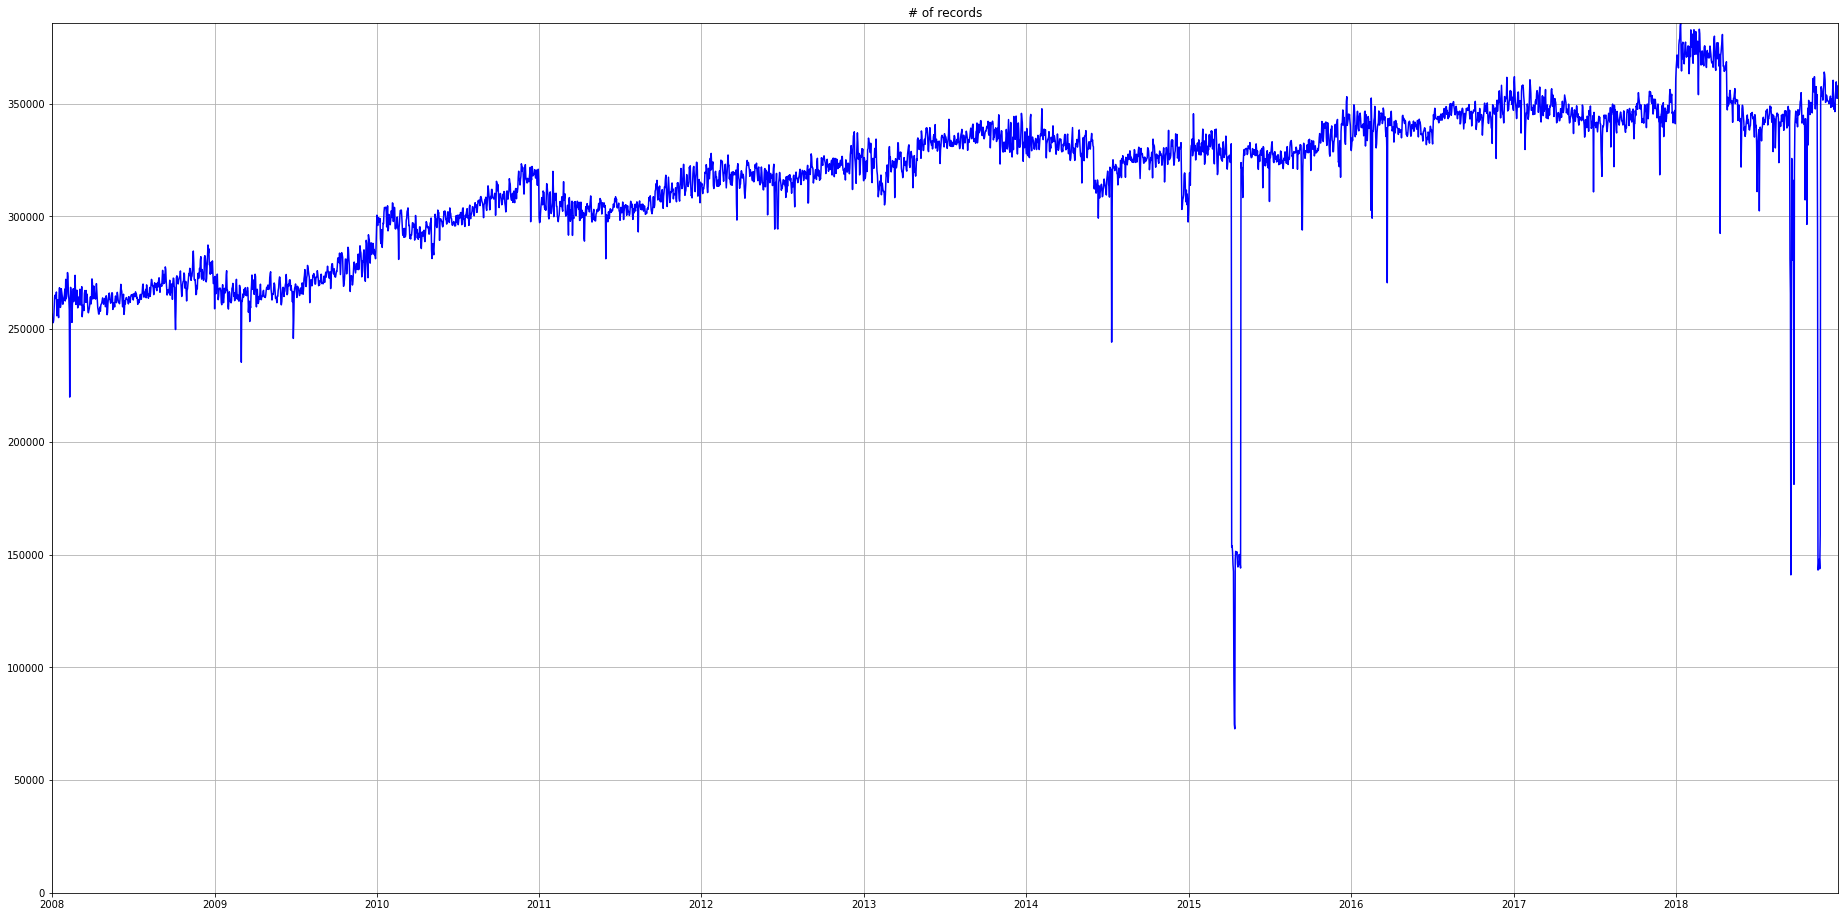

In [63]:
plt.figure(figsize=(32, 16))
plt.plot(counts, color='b')
plt.title('# of records')
plt.ylim([0, max(counts)])
plt.xlim([datetime(y1, 1, 1), datetime(y2, 12, 31)])
plt.grid()

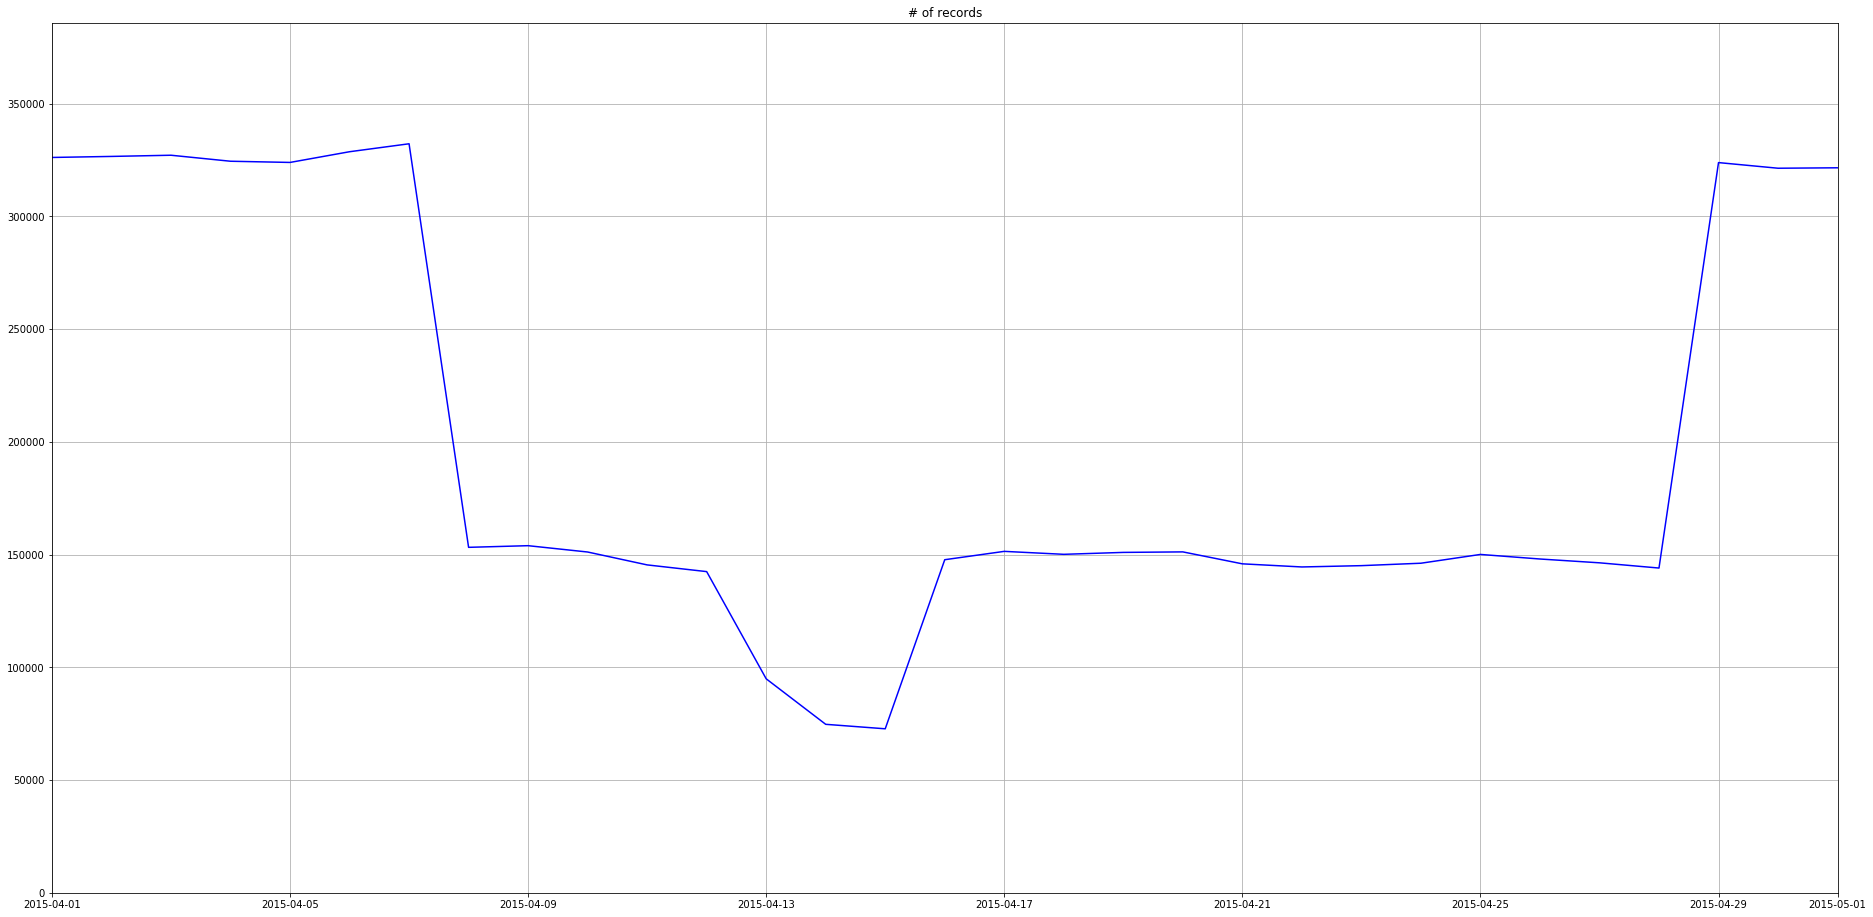

In [65]:
plt.figure(figsize=(32, 16))
plt.plot(counts, color='b')
plt.title('# of records')
plt.ylim([0, max(counts)])
plt.xlim([datetime(2015, 4, 1), datetime(2015, 5, 1)])
plt.grid()

In [74]:
temp = df.groupby('stationName')['year'].count().compute()

In [81]:
stations = df.stationName.unique().compute()

In [85]:
stations

0             CEDAR CITY REGIONAL ARPT
1                               JAFFNA
2                              IQALUIT
3                             OTTOSDAL
4                                LINXI
5        ARMIDALE (TREE GROUP NURSERY)
6                              GADDEDE
7                               KANOYA
8           PORTLAND-HILLSBORO AIRPORT
9                                LISHI
10                       GUNNEDAH POOL
11                HOLLOMAN AFB AIRPORT
12                 VICTORIA FALLS INTL
13                              KERANG
14                            BROOKTON
15                BULL BAY (LAURISTON)
16                            DORTMUND
17                        CHILEKA INTL
18                   NERRIGA COMPOSITE
19                        MAROUA-SALAK
20                               GOKWE
21                             KEMPSEY
22                SEARLE FIELD AIRPORT
23                               MAMOU
24         MOOGARA (UXBRIDGE BACK ROAD
25                       

In [143]:
df.temperature.min().compute()

-88.6

In [144]:
df.temperature.max().compute()

61.7

In [146]:
df.elevation.max().compute()

9999.0

In [147]:
df.elevation.min().compute()

-388.0

In [156]:
df.elevation.max().compute()

nan

In [89]:
temp

stationName
068: BAFFIN BAY; POINT OF ROCKS  TX          17325
23 NAUTICAL MILES SOUTHWEST OF MONTAUK P     18160
30NM SOUTHWEST OF MIZEN HEAD                 17071
9014098 - FORT GRATIOT  MI                   20058
9052030 - OSWEGO  NY                         20094
9063020 - BUFFALO  NY                        20053
9075014 - HARBOR BEACH  MI                   20089
9075099 - DE TOUR VILLAGE  MI                19914
9076024 - ROCK CUT  MI                       20082
9076070 - S.W. PIER  MI                      20078
9087023 - LUDINGTON  MI                      20026
9087044 - CALUMET  IL                        20079
9099004 - POINT IROQUOIS  MI                 20096
9099018 - MARQUETTE C.G.  MI                 20090
9099090 - GRAND MARAIS  MN                   20002
A CORUNA                                    191672
A L MANGHAM JR RGNL ARPT                    260486
A511/PYEONGTAEK                             136520
AADORF-TAENIKON                              94763
AARHUS             

In [118]:
df.dtypes

usaf                               object
wban                               object
datetime                   datetime64[ns]
latitude                          float64
longitude                         float64
elevation                         float64
windAngle                           int32
windSpeed                         float64
temperature                       float64
seaLvlPressure                    float64
cloudCoverage                      object
presentWeatherIndicator             int32
pastWeatherIndicator                int32
precipTime                        float64
precipDepth                       float64
snowDepth                         float64
stationName                        object
countryOrRegion                    object
p_k                                object
year                                int32
day                                 int32
version                           float64
dtype: object

In [139]:
temp = df[df['year']==2015]
temp['month'] = df['datetime'].dt.month
temp = temp[(temp.month > 2) & (temp.month < 6)]
places = temp.groupby(temp.datetime.dt.floor('d'))['longitude', 'latitude', 'month'].mean().compute()

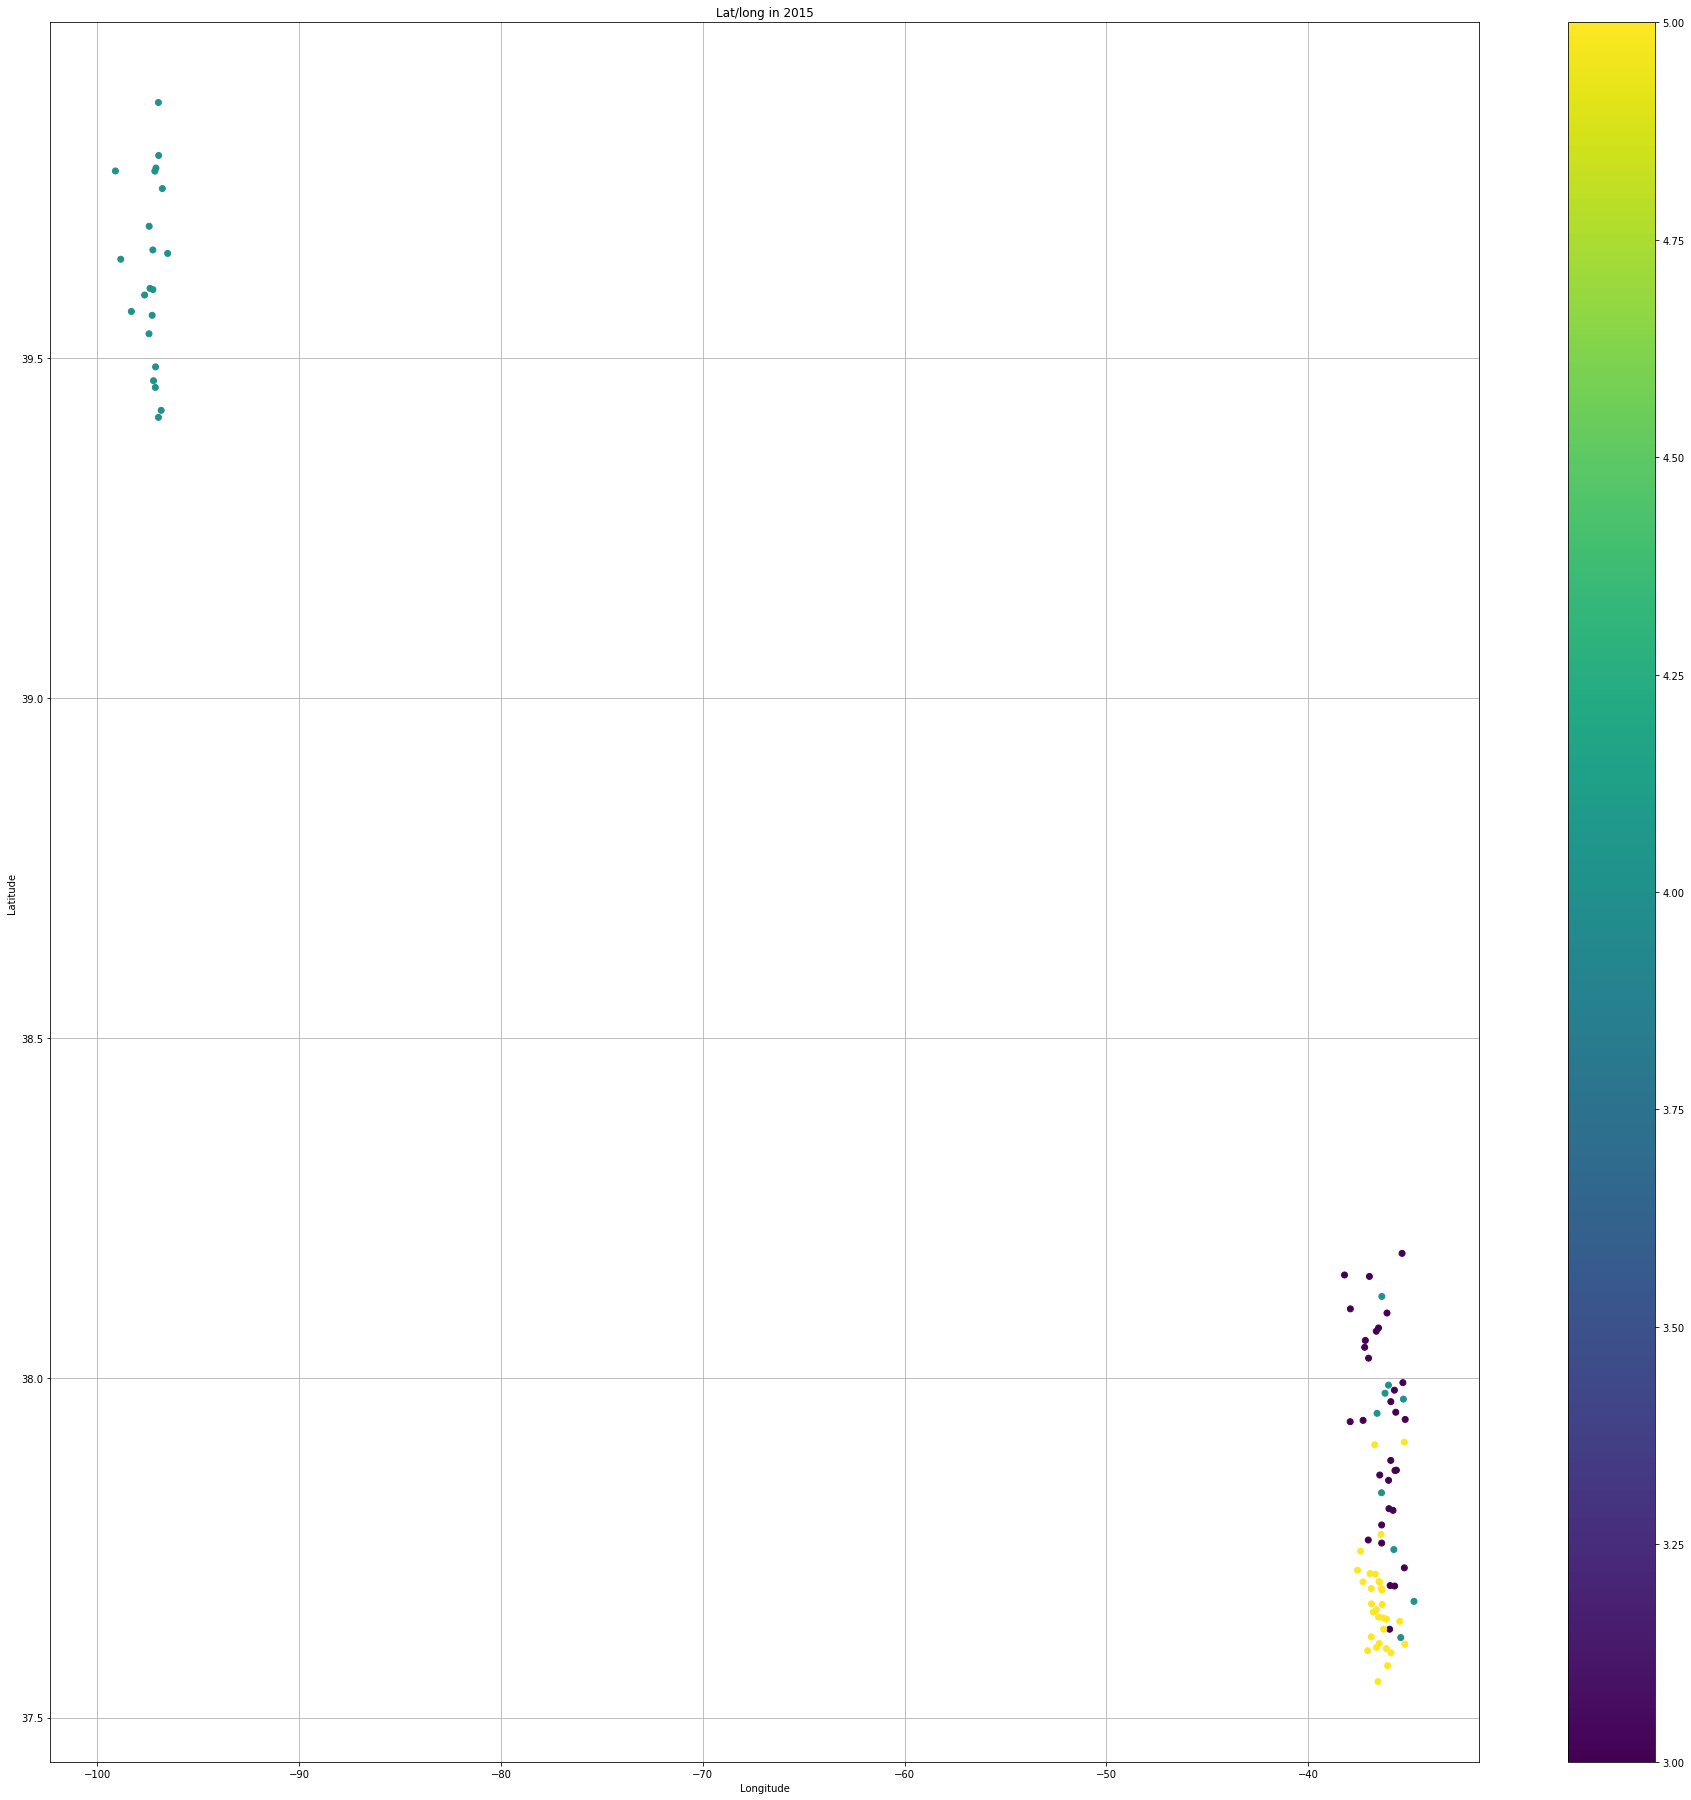

In [165]:
plt.figure(figsize=(32, 32))
plt.scatter(places.longitude, places.latitude, c=places['month'])
plt.title('Lat/long in 2015')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.colorbar()

## End the run

Cluster will return to 0 nodes

In [164]:
c.close()
run.cancel()